This notebook contains the code for the experiments in the work _"Análisis del espacio latente en el auto-encoder variacional"_. The main goal of the notebook is to compare the representations obtained using a standard auto-encoder and a variational auto-encoder from the point of view of the separation of the classes in a classification data set.

In [1]:
import tensorflow as tf

Let's first check if there is any GPU available. There is not any need to use a GPU to execute this notebook. However it will require less time to execute using a GPU than just using a CPU.

In [2]:
if tf.test.gpu_device_name() != '/device:GPU:0':
    print('WARNING: GPU device not found.')

else:
    print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

SUCCESS: Found GPU: /device:GPU:0


2022-06-20 08:02:36.448817: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-20 08:02:36.518664: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-20 08:02:36.630271: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-20 08:02:36.630495: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

# Loading the MNIST data

To compare the representations from the models considered in the experiments we are using the MNIST data set that contains 60,000 images of handwritten digits that are labeled using the digit represented in the image. This data set is easy enough to get the conclusions we expect from these experiments.


## Creating of the training pipeline

The training data is provided to the fitting algorithm using a data pipeline that includes the data required.

In [3]:
import os

import tensorflow_datasets as tfds

We define the data pipeline as a class that is responsible of downloading the MNIST data set using the `TensorFlow Datasets` library. The downloaded data is transformed using the `tensorflow.data.Dataset` interface.

In [4]:
class Pipeline:

    def __init__(self, datadir='.'):
        self.datadir = datadir

    def training(self, batch_size):
        dataset = self._load(split='train[:50000]')
        dataset = self._transform(dataset, batch_size=batch_size)
        return dataset

    def validation(self, batch_size):
        dataset = self._load(split='train[50000:]')
        dataset = self._transform(dataset, batch_size=batch_size)
        return dataset

    def _load(self, split):
        return tfds.load(
            name='mnist:3.0.1',
            split=split,
            data_dir=self.datadir)

    def _transform(self, dataset, batch_size=1):
        dataset = dataset.shuffle(buffer_size=60000)
        dataset = dataset.batch(batch_size=batch_size)
        dataset = dataset.map(
            map_func=self._process_batch,
            num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

        return dataset

    def _process_batch(self, batch):
        image = batch['image']
        image = self._normalize_image(image)
        return image

    def _normalize_image(self, image):
        image = tf.cast(image, tf.float32)
        image = image / 255
        return image

Once the data pipeline is defined we just need to create an instace:

In [5]:
basedir = os.path.dirname(os.getcwd())
datadir = os.path.join(basedir, '.data')

pipeline = Pipeline(datadir)

We are now creating the training and validation data sets and downloading the data (this detail is managed by the TensorFlow Datasets library and will only be executed if data is not already downloaded to the provided `datadir` argument.

In [6]:
training_data = pipeline.training(batch_size=100)
validation_data = pipeline.validation(batch_size=100)

2022-06-20 08:02:38.192505: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-20 08:02:38.192726: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-20 08:02:38.192864: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-20 08:02:38.193233: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-20 08:02:38.193381: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

## Preparing the evaluation data

In [7]:
from tensorflow.keras.datasets import mnist

The `Keras` library includes the MNIST data ready to be used. We only require to load the evaluation data to perform the experiments:

In [8]:
_, (evaluation_images, evaluation_labels) = mnist.load_data()

As we did for the training data sets, we are transforming the values from integers between 0 to 255 into real numbers in the range [0, 1]:

In [9]:
evaluation_images = evaluation_images.astype(float) / 255
evaluation_images = evaluation_images.reshape([-1, 28, 28, 1])

# Modeling the MNIST data

We are now building the base models we are using for the experiments. Remember we are comparing a standard auto-encoder to a variational auto-encoder.

In [10]:
from matplotlib import pyplot

from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Reshape

from tensorflow.keras.losses import binary_crossentropy

from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam

We are interested in making both the *auto-encoder* and the *variational auto-encoder* as similar as possible to focus our discussion in the main difference of both models. We are defining some hyper-parameters to be the same for both models:

* the number of `HIDDEN_UNITS` is the number of neurons that will use the encoder and the decoder of both models and,

* the `LATENT_SIZE` is the number of elements of the representation to be learned by the encoder of both models.

In [11]:
HIDDEN_UNITS = 300
LATENT_SIZE = 10

Both models will share the same definition for the decoder (or generation model). The only differences between the auto-encoder and the variational auto-encoder is the recognition model (or encoder) and the training algorithm.

In [12]:
class Decoder(Model):

    def __init__(self, hidden_units, latent_size, name=None):
        sample = Input(shape=[latent_size])
        hidden = Dense(units=hidden_units, activation=LeakyReLU())(sample)
        features = Dense(units=784, activation='sigmoid')(hidden)
        image = Reshape(target_shape=[28, 28, 1])(features)

        super(Decoder, self).__init__(
            inputs=sample,
            outputs=image,
            name=name)

## Building the baseline auto-encoder

The encoder for the auto-encoder is just a model simple MLP with a single hidden layer. Note the model requires the MNIST image as input.

In [13]:
class SimpleEncoder(Model):
    
    def __init__(self, hidden_units, latent_size, name=None):
        image = Input(shape=[28, 28, 1])
        features = Flatten()(image)
        hidden = Dense(units=hidden_units, activation=LeakyReLU())(features)
        encoding = Dense(units=latent_size)(hidden)
        
        super(SimpleEncoder, self).__init__(
            inputs=image,
            outputs=encoding,
            name=name)

We provide the number of `HIDDEN_UNITS` and the `LATENT_SIZE` to create a simple encoder that will be used on the auto-encoder instantiation.

In [14]:
simple_encoder = SimpleEncoder(
    hidden_units=HIDDEN_UNITS,
    latent_size=LATENT_SIZE,
    name='simple-encoder')

simple_encoder.summary()

Model: "simple-encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 10)                3010      
                                                                 
Total params: 238,510
Trainable params: 238,510
Non-trainable params: 0
_________________________________________________________________


The same way as for the encoder, we instantiate the decoder we are using for the AE using the decoder definition we are using for both the AE and the VAE.

In [15]:
ae_decoder = Decoder(
    hidden_units=HIDDEN_UNITS,
    latent_size=LATENT_SIZE,
    name='ae-decoder')

ae_decoder.summary()

Model: "ae-decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_2 (Dense)             (None, 300)               3300      
                                                                 
 dense_3 (Dense)             (None, 784)               235984    
                                                                 
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
Total params: 239,284
Trainable params: 239,284
Non-trainable params: 0
_________________________________________________________________


Now lets define the model for the AE. Note this model is not really required. However this definition eases training because the `Model` base class implements a training loop. If we do not use this model we need to implement such training loop.

In [16]:
class VanillaAE(Model):
    
    def __init__(self, encoder, decoder, name=None):
        super(VanillaAE, self).__init__(name)
        self._encoder = encoder
        self._decoder = decoder
        
    def call(self, image, training=False):
        encoding = self._encoder(image)
        reconst = self._decoder(encoding)
        
        reconst_loss = self._reconst_loss(image, reconst)
        self.add_loss(reconst_loss)
        
        return reconst

    def _reconst_loss(self, original, reconstructed):
        loss = binary_crossentropy(original, reconstructed)
        loss = tf.reduce_sum(loss, axis=[1, 2])
        loss = tf.reduce_mean(loss)
        return loss

The instantiation of the AE just needs one instance of the encoder and another instance of the decoder we are using.

In [17]:
ae = VanillaAE(
    encoder=simple_encoder,
    decoder=ae_decoder,
    name='vanilla-ae')

### Fitting the auto-encoder to the MNIST data

Once we have defined the AE we are fitting the model to the MNIST data. The first step is to compile the model using an optimizer.

In [18]:
adam = Adam(learning_rate=1e-3)
ae.compile(optimizer=adam)

We are now using the fit method provided by the Model base class to perform actually fit the AE.

In [19]:
ae_history = ae.fit(
    x=training_data,
    validation_data=validation_data,
    epochs=30,
    verbose=1)

Epoch 1/30
500/500 [==============================] - 5s 3ms/step - loss: 142.8093 - val_loss: 112.3857
Epoch 2/30
500/500 [==============================] - 1s 3ms/step - loss: 106.7153 - val_loss: 103.0272
Epoch 3/30
500/500 [==============================] - 1s 3ms/step - loss: 100.2458 - val_loss: 98.5408
Epoch 4/30
500/500 [==============================] - 1s 3ms/step - loss: 96.7261 - val_loss: 95.9556
Epoch 5/30
500/500 [==============================] - 1s 2ms/step - loss: 94.4053 - val_loss: 93.8968
Epoch 6/30
500/500 [==============================] - 1s 3ms/step - loss: 92.7014 - val_loss: 92.5746
Epoch 7/30
500/500 [==============================] - 2s 3ms/step - loss: 91.3772 - val_loss: 91.3979
Epoch 8/30
500/500 [==============================] - 1s 2ms/step - loss: 90.3073 - val_loss: 90.5572
Epoch 9/30
500/500 [==============================] - 1s 3ms/step - loss: 89.4742 - val_loss: 89.7624
Epoch 10/30
500/500 [==============================] - 1s 3ms/step - loss: 88

Let us take a look to the loss from the fitting algorithm:

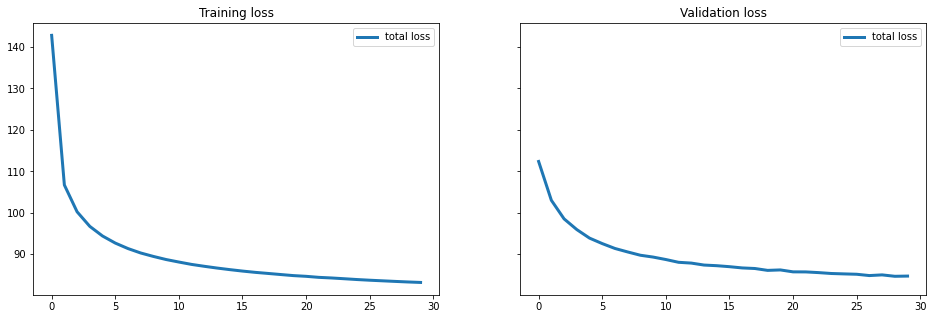

In [20]:
_, (train_plot, val_plot) = pyplot.subplots(nrows=1, ncols=2, figsize=(16,5), sharey=True)

train_plot.plot(ae_history.history['loss'], linewidth=3, label='total loss')
train_plot.set_title('Training loss')
train_plot.legend()

val_plot.plot(ae_history.history['val_loss'], linewidth=3, label='total loss')
val_plot.set_title('Validation loss')
val_plot.legend()

pyplot.show()

## Building the variational auto-encoder

We are building the encoder for the VAE as similar as possible to the encoder of the original auto-encoder. The main difference is the outputs of the model. Here we are returning the parameters os the posterior distribution learned by the encoder. That is, the mean vector and the diagonal of the covariance matrix (since the VAE asumes the posterior is an isotropic gaussian):

In [21]:
class GaussianEncoder(Model):
    
    def __init__(self, hidden_units, latent_size, name=None):
        image = Input(shape=[28, 28, 1])
        features = Flatten()(image)
        hidden = Dense(units=hidden_units, activation=LeakyReLU())(features)
        mean = Dense(units=latent_size)(hidden)
        logvar = Dense(units=latent_size)(hidden)
        
        super(GaussianEncoder, self).__init__(
            inputs=image,
            outputs=[mean, logvar],
            name=name)

Once we defined the `GaussianEncoder` we can create the instance we are using for the variational auto-encoder:

In [22]:
gaussian_encoder = GaussianEncoder(
    hidden_units=HIDDEN_UNITS,
    latent_size=LATENT_SIZE,
    name='gaussian-encoder')

gaussian_encoder.summary()

Model: "gaussian-encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 flatten_1 (Flatten)            (None, 784)          0           ['input_3[0][0]']                
                                                                                                  
 dense_4 (Dense)                (None, 300)          235500      ['flatten_1[0][0]']              
                                                                                                  
 dense_5 (Dense)                (None, 10)           3010        ['dense_4[0][0]']                
                                                                                   

The same way we did in the auto-encoder, we are creating an instance of the same decoder for the variational auto-encoder to make a fair comparison of the generated images:

In [23]:
vae_decoder = Decoder(
    hidden_units=HIDDEN_UNITS,
    latent_size=LATENT_SIZE,
    name='vae-decoder')

vae_decoder.summary()

Model: "vae-decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_7 (Dense)             (None, 300)               3300      
                                                                 
 dense_8 (Dense)             (None, 784)               235984    
                                                                 
 reshape_1 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
Total params: 239,284
Trainable params: 239,284
Non-trainable params: 0
_________________________________________________________________


The sampling layer below is the implementation of the _reparameterization trick_ that makes differentiable the stocastic network of the variational auto-encoder. It is responsible of sampling from a multivariate normal distribution:

In [24]:
class Sampling(Layer):
    
    def call(self, inputs):
        mean, logvar = inputs
        shape = tf.shape(mean)
        epsilon = tf.random.normal(shape=shape)
        sample = mean + tf.exp(0.5 * logvar) * epsilon
        return sample

We now define the base model we are using for the variational auto-encoder. Here we implemented the forward pass (in the `call` method) that includes sampling from the gaussian posterior learned by the encoder provided. Note the loss function is here divided into the `_recons_loss` that computes the reconstruction error and the `_diverg_loss` that computes the _"distance"_ from the aproximate posterior to the prior distribution:

In [25]:
class BetaVAE(Model):
    
    def __init__(self, encoder, decoder, beta=1, name=None):
        super(BetaVAE, self).__init__(name)
        self._encoder = encoder
        self._decoder = decoder
        self._beta = beta
        self._sampler = Sampling()
        
    def call(self, image, training=False):
        mean, logvar = self._encoder(image)
        sample = self._sampler([mean, logvar])
        reconst = self._decoder(sample)
        
        reconst_loss = self._reconst_loss(image, reconst)
        self.track_loss(reconst_loss, name='reconst_loss')
        
        diverg_loss = self._diverg_loss(mean, logvar)
        diverg_loss *= self._beta
        self.track_loss(diverg_loss, name='diverg_loss')
        
        return reconst

    def track_loss(self, loss, name):
        self.add_loss(loss)
        self.add_metric(loss, name=name)
    
    def _reconst_loss(self, original, reconstructed):
        loss = binary_crossentropy(original, reconstructed)
        loss = tf.reduce_sum(loss, axis=[1, 2])
        loss = tf.reduce_mean(loss)
        return loss
    
    def _diverg_loss(self, mean, logvar):
        loss = -0.5 * (1 + logvar - tf.square(mean) - tf.exp(logvar))
        loss = tf.reduce_sum(loss, axis=1)
        loss = tf.reduce_mean(loss)
        return loss

Now we are ready to create an instance of the variational auto-encoder we have implemented using an instance of the decoder and an instance of the gaussian encoder. Note the `beta` hyperparameter equal to 1 that makes the $\beta$-VAE model equal to a simple variational autoencoder:

In [26]:
vae = BetaVAE(
    encoder=gaussian_encoder,
    decoder=vae_decoder,
    beta=1,
    name='beta-vae')

### Fitting the variational auto-encoder to the MNIST data

We have defined the variationa auto-encoder. We now just need to compile the model using the Adam obtimized as we did in the auto-encoder before fitting to the MNIST data:

In [27]:
adam = Adam(learning_rate=1e-3)
vae.compile(optimizer=adam)

The last step is to execute the fitting algorithm that cames with the Keras library:

In [28]:
vae_history = vae.fit(
    x=training_data,
    validation_data=validation_data,
    epochs=30,
    verbose=1)

Epoch 1/30
500/500 [==============================] - 3s 4ms/step - loss: 170.7279 - reconst_loss: 152.9775 - diverg_loss: 17.7506 - val_loss: 140.3388 - val_reconst_loss: 123.7832 - val_diverg_loss: 16.5556
Epoch 2/30
500/500 [==============================] - 2s 4ms/step - loss: 134.7438 - reconst_loss: 118.1974 - diverg_loss: 16.5464 - val_loss: 130.7547 - val_reconst_loss: 114.5798 - val_diverg_loss: 16.1749
Epoch 3/30
500/500 [==============================] - 2s 3ms/step - loss: 127.8445 - reconst_loss: 111.3603 - diverg_loss: 16.4843 - val_loss: 126.0042 - val_reconst_loss: 109.2526 - val_diverg_loss: 16.7516
Epoch 4/30
500/500 [==============================] - 2s 4ms/step - loss: 124.0457 - reconst_loss: 107.2712 - diverg_loss: 16.7746 - val_loss: 122.9827 - val_reconst_loss: 106.1050 - val_diverg_loss: 16.8777
Epoch 5/30
500/500 [==============================] - 2s 3ms/step - loss: 121.6985 - reconst_loss: 104.7226 - diverg_loss: 16.9759 - val_loss: 121.3013 - val_reconst_lo

Let us take a look to the loss from the fitting algorithm:

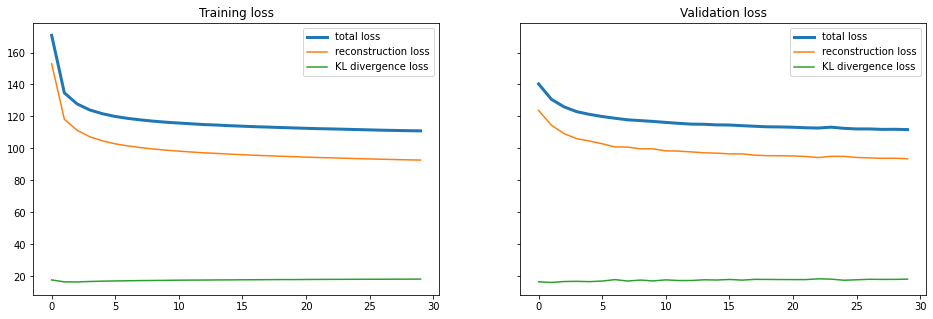

In [29]:
_, (train_plot, val_plot) = pyplot.subplots(nrows=1, ncols=2, figsize=(16,5), sharey=True)

train_plot.plot(vae_history.history['loss'], linewidth=3, label='total loss')
train_plot.plot(vae_history.history['reconst_loss'], label='reconstruction loss')
train_plot.plot(vae_history.history['diverg_loss'], label='KL divergence loss')
train_plot.set_title('Training loss')
train_plot.legend()

val_plot.plot(vae_history.history['val_loss'], linewidth=3, label='total loss')
val_plot.plot(vae_history.history['val_reconst_loss'], label='reconstruction loss')
val_plot.plot(vae_history.history['val_diverg_loss'], label='KL divergence loss')
val_plot.set_title('Validation loss')
val_plot.legend()

pyplot.show()

# Comparison of the fitted models

In this section we conduct several experiments that provide us a better understanding of the latent space of the VAE by comparing the representations of a standard auto-encoder and a variational auto-encoder.

In [30]:
import numpy

In [31]:
NUM_SAMPLES = 10

## How well do the models reconstruct some sample data?

The goal of this experiment is just to check that both the auto-encoder and the variational auto-encoder are correctly implemented. We should expect reconstructions to be fairly similar to original images.

The first step is just to select the first `NUM_SAMPLES` images from the evaluation data set:

In [32]:
original_images = evaluation_images[:NUM_SAMPLES]

Now we just need to generate the reconstructed images using both models:

In [33]:
ae_reconstructed_images = ae(original_images)
vae_reconstructed_images = vae(original_images)

The first row of images of the following plot shows the original images. The second and third rows are the reconstructed images from the auto-encoder and the variational auto-encoder:

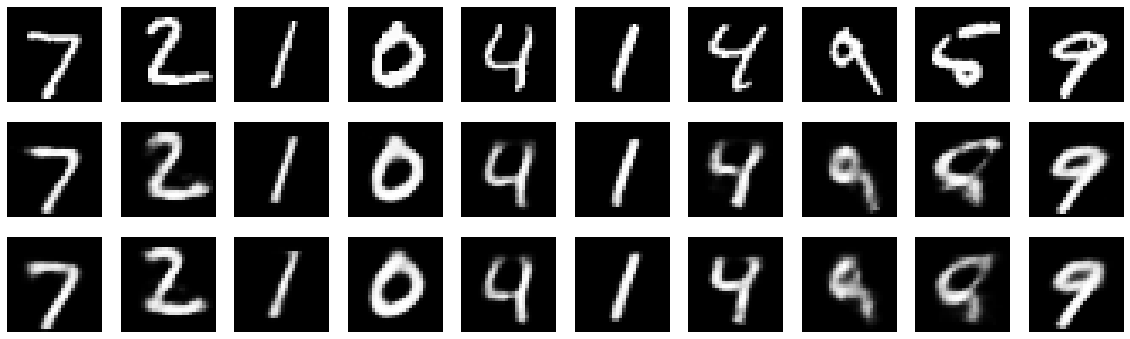

In [34]:
_, plots = pyplot.subplots(nrows=3, ncols=NUM_SAMPLES, figsize=(20, 6))

for index in range(NUM_SAMPLES):
    original_plot = plots[0, index]
    original_plot.imshow(original_images[index], cmap='gray')
    original_plot.axis('off')
        
    ae_plot = plots[1, index]
    ae_plot.imshow(ae_reconstructed_images[index], cmap='gray')
    ae_plot.axis('off')

        
    vae_plot = plots[2, index]
    vae_plot.imshow(vae_reconstructed_images[index], cmap='gray')
    vae_plot.axis('off')

pyplot.show()

## How well do the models generate new data?

This experiment is designed to highlight the main difference between the auto-encoder and the variational auto-encoder. Here we experiment withe the _decoder_ fitted using both models. We expect the auto-encoder performs OK when generating images whose representations are similar to the representation of the real images and not very good when the representations come from samples of the posterior distribution.

### Generating images from classes means

The goal of this experiment is to show that both the auto-encoder and the variational auto-encoder are able to genenerate images using "known" representations. The representation build by averaging all the representations a class will be similar to the representations of the images in that class. We expect both models to generate nice images.

In [35]:
from sklearn.neighbors import NearestCentroid

We use the `NearestCentroid` model from the `scikit-learn` library to get the mean of each class in the representations from a data set:

In [36]:
def centroids(embeddings, labels):
    classifier = NearestCentroid()
    classifier.fit(embeddings, labels)

    return classifier.centroids_

To build the representations used to generate images from the _decoder_ trained using the auto-encoder we just calculate the centroids of the representations for each class:

In [37]:
ae_encodings = simple_encoder(evaluation_images)
ae_centroids = centroids(ae_encodings, evaluation_labels)

Then we just need to use the _decoder_ to generate some images from the centroids of the images:

In [38]:
ae_generated_images = ae_decoder(ae_centroids)

To build the representations used to generate images from the _decoder_ trained using the variational auto-encoder we just calculate the centroids of the representations for each class:

In [39]:
vae_encodings, _  = gaussian_encoder(evaluation_images)
vae_centroids = centroids(vae_encodings, evaluation_labels)

Then we just need to use the _decoder_ to generate some images from the centroids of the images:

In [40]:
vae_generated_images = vae_decoder(vae_centroids)

The following images are the results of the generation process. The first row shows the images generated using the _decoder_ trained using the auto-encoder. The second row shows the images generated using the _decoder_ trained using the variational auto-encoder.

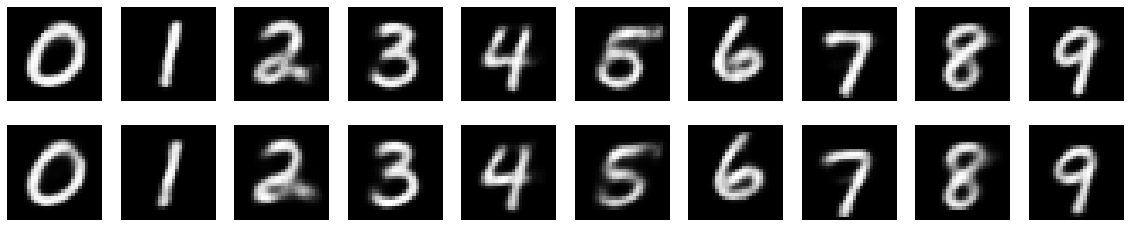

In [41]:
_, plots = pyplot.subplots(nrows=2, ncols=NUM_SAMPLES, figsize=(20, 4))

for index in range(NUM_SAMPLES):
    ae_plot = plots[0, index]
    ae_plot.imshow(ae_generated_images[index], cmap='gray')
    ae_plot.axis('off')

    vae_plot = plots[1, index]
    vae_plot.imshow(vae_generated_images[index], cmap='gray')
    vae_plot.axis('off')

pyplot.show()

As we expected both models can generate images from the mean representation of each class. The auto-encoder is not a generative model because the latent space it learns _"has a lot of holes"_, that is only some of the values of the latent space contain representations that correspond to real images. The centroid, that is the average of all the representations of a class, does correspond to a valid image.

### Generating images from samples of the prior distribution

...

The first step is to draw `NUM_SAMPLES` samples from the gaussian prior we used to fir the variational auto-encoder:

In [42]:
random_samples = numpy.random.normal(size=[NUM_SAMPLES, LATENT_SIZE])

Now we just need to use the _decoder_ of both models to get some generated images:

In [43]:
ae_generated_images = ae_decoder(random_samples)
vae_generated_images = vae_decoder(random_samples)

The following images are the results of the generation process. The first row shows the images generated using the _decoder_ trained using the auto-encoder. The second row shows the images generated using the _decoder_ trained using the variational auto-encoder.

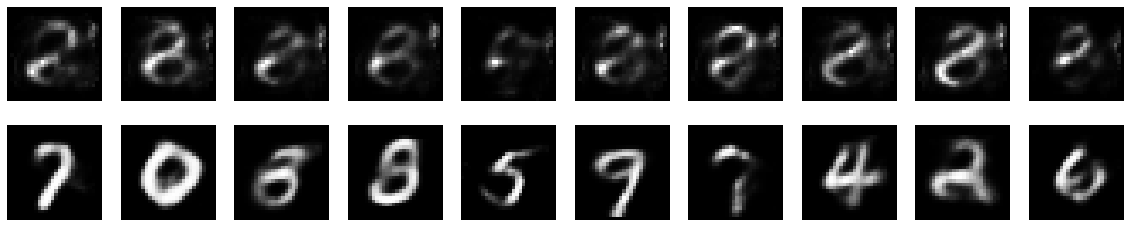

In [44]:
_, plots = pyplot.subplots(nrows=2, ncols=NUM_SAMPLES, figsize=(20, 4))

for index in range(NUM_SAMPLES):
    ae_plot = plots[0, index]
    ae_plot.imshow(ae_generated_images[index], cmap='gray')
    ae_plot.axis('off')

    vae_plot = plots[1, index]
    vae_plot.imshow(vae_generated_images[index], cmap='gray')
    vae_plot.axis('off')

pyplot.show()

This is the main difference we expected. The images generated from the decoder trained using an AE do not seem as hand-written digits while the images produced by the decoder trained using a VAE seem like numbers.

We can think that the decoder may not be enough powerful to generate the images and that may be the case, but remember that we used the same decoder definition for both training algorithms. The only real difference is that the latent space learnt using the VAE can be seen as a manifold, that is, the decoder trained using a VAE has the ability to generate images from the probability distribution enforced by the encoder.

However, we hypothesize that the decoder used here is not powerful enough to generate high quality hand-written digits.

## Can a better VAE improve the image generation?

From the previous experiment we noticed that the images generated using the VAE look like numbers but they are too naive. This experiment aims to build a VAE with more powerful encoder and decoder models. The hypothesis here is that better models may provide better generated images.

In [45]:
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose

### Building a _Convolutional VAE_

The convolutional encoder bellow differs from the original gaussian encoder in that the hidden layer was replace by some convolutional layers that are specialized in estracting more useful features from images:

In [46]:
class ConvolutionalEncoder(Model):
    
    def __init__(self, hidden_units, latent_size, name=None):
        image = Input(shape=[28, 28, 1])
        maps = Conv2D(
            filters=32, kernel_size=5, strides=1,
            padding='same', activation=LeakyReLU())(image)
        maps = Conv2D(
            filters=32, kernel_size=5, strides=2,
            padding='same', activation=LeakyReLU())(maps)
        maps = Conv2D(
            filters=64, kernel_size=5, strides=1,
            padding='same', activation=LeakyReLU())(maps)
        maps = Conv2D(
            filters=64, kernel_size=5, strides=2,
            padding='same', activation=LeakyReLU())(maps)
        maps = Conv2D(
            filters=128, kernel_size=7, strides=1,
            padding='valid', activation=LeakyReLU())(maps)
        features = Flatten()(maps)

        mean = Dense(units=latent_size)(features)
        logvar = Dense(units=latent_size)(features)
        
        super(ConvolutionalEncoder, self).__init__(
            inputs=image,
            outputs=[mean, logvar],
            name=name)

We now instantiate the encoder we have already implemented and take a look to its architecture:

In [47]:
convolutional_encoder = ConvolutionalEncoder(
    hidden_units=HIDDEN_UNITS,
    latent_size=LATENT_SIZE,
    name='convolutional-encoder')

convolutional_encoder.summary()

Model: "convolutional-encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 32)   832         ['input_5[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 14, 32)   25632       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 14, 14, 64)   51264       ['conv2d_1[0][0]']               
                                                                              

For the decoder bellow we replaced the hidden layer of the original decoder with some transposed convolutions thrat _"revert"_ the features extracted back to the image:

In [48]:
class ConvolutionalDecoder(Model):

    def __init__(self, hidden_units, latent_size, name=None):
        sample = Input(shape=[latent_size])
        maps = Reshape(target_shape=[1, 1, latent_size])(sample)
        maps = Conv2DTranspose(
            filters=64, kernel_size=7, strides=1,
            padding='valid', activation=LeakyReLU())(maps)
        maps = Conv2DTranspose(
            filters=64, kernel_size=5, strides=1,
            padding='same', activation=LeakyReLU())(maps)
        maps = Conv2DTranspose(
            filters=64, kernel_size=5, strides=2,
            padding='same', activation=LeakyReLU())(maps)
        maps = Conv2DTranspose(
            filters=32, kernel_size=5, strides=1,
            padding='same', activation=LeakyReLU())(maps)
        maps = Conv2DTranspose(
            filters=32, kernel_size=5, strides=2,
            padding='same', activation=LeakyReLU())(maps)
        maps = Conv2DTranspose(
            filters=32, kernel_size=5, strides=1,
            padding='same', activation=LeakyReLU())(maps)

        image = Conv2D(
            filters=1, kernel_size=5, strides=1,
            padding='same', activation='sigmoid')(maps)

        super(ConvolutionalDecoder, self).__init__(
            inputs=sample,
            outputs=image,
            name=name)

We are also instantiating the imporved decoder and taking a look to its architecture:

In [49]:
convolutional_decoder = ConvolutionalDecoder(
    hidden_units=HIDDEN_UNITS,
    latent_size=LATENT_SIZE,
    name='convolutional-decoder')

convolutional_decoder.summary()

Model: "convolutional-decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 10)]              0         
                                                                 
 reshape_2 (Reshape)         (None, 1, 1, 10)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 64)         31424     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 7, 7, 64)         102464    
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 14, 14, 64)       102464    
 ranspose)                                                       
                                             

To make as fair as we can comparison between the original VAE and the new convolutional VAE we are using to train the encoder and decoder models the same implementation of the $\beta$-VAE:

In [50]:
conv_vae = BetaVAE(
    encoder=convolutional_encoder,
    decoder=convolutional_decoder,
    beta=1,
    name='convolutional-vae')

The same way as the training of the auto-encoder and the variational auto-encoder we are using the same optimizer when compiling the model:

In [51]:
adam = Adam(learning_rate=1e-3)
conv_vae.compile(optimizer=adam)

Le us now fit the convolutional VAE to the MNIST data. The new VAE is bigget than the original so training will spend a bit more time:

In [52]:
conv_vae_history = conv_vae.fit(
    x=training_data,
    validation_data=validation_data,
    epochs=30,
    verbose=1)

Epoch 1/30


2022-06-20 08:04:26.638991: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302
2022-06-20 08:04:28.062636: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


500/500 [==============================] - 14s 22ms/step - loss: 149.2462 - reconst_loss: 135.0502 - diverg_loss: 14.1960 - val_loss: 115.4054 - val_reconst_loss: 98.2984 - val_diverg_loss: 17.1070
Epoch 2/30
500/500 [==============================] - 11s 21ms/step - loss: 111.5644 - reconst_loss: 93.3372 - diverg_loss: 18.2273 - val_loss: 108.8758 - val_reconst_loss: 90.5042 - val_diverg_loss: 18.3716
Epoch 3/30
500/500 [==============================] - 11s 22ms/step - loss: 107.9680 - reconst_loss: 89.3466 - diverg_loss: 18.6213 - val_loss: 106.9991 - val_reconst_loss: 88.3050 - val_diverg_loss: 18.6940
Epoch 4/30
500/500 [==============================] - 11s 22ms/step - loss: 105.6400 - reconst_loss: 86.8675 - diverg_loss: 18.7725 - val_loss: 104.9734 - val_reconst_loss: 85.7483 - val_diverg_loss: 19.2251
Epoch 5/30
500/500 [==============================] - 11s 22ms/step - loss: 104.2693 - reconst_loss: 85.3910 - diverg_loss: 18.8784 - val_loss: 103.8073 - val_reconst_loss: 84.99

Let us take a look to the loss from the fitting algorithm:

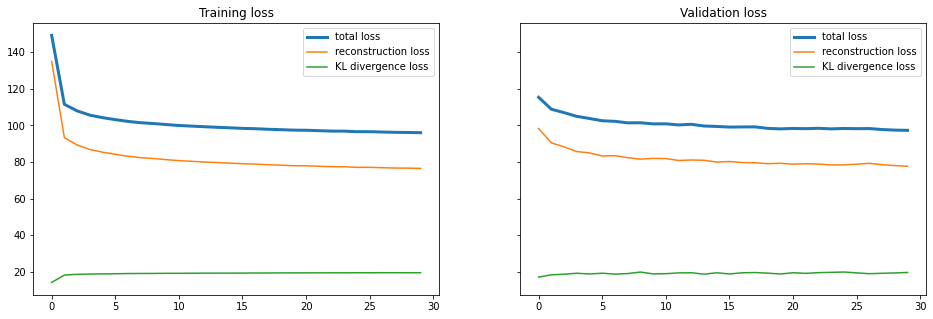

In [53]:
_, (train_plot, val_plot) = pyplot.subplots(nrows=1, ncols=2, figsize=(16,5), sharey=True)

train_plot.plot(conv_vae_history.history['loss'], linewidth=3, label='total loss')
train_plot.plot(conv_vae_history.history['reconst_loss'], label='reconstruction loss')
train_plot.plot(conv_vae_history.history['diverg_loss'], label='KL divergence loss')
train_plot.set_title('Training loss')
train_plot.legend()

val_plot.plot(conv_vae_history.history['val_loss'], linewidth=3, label='total loss')
val_plot.plot(conv_vae_history.history['val_reconst_loss'], label='reconstruction loss')
val_plot.plot(conv_vae_history.history['val_diverg_loss'], label='KL divergence loss')
val_plot.set_title('Validation loss')
val_plot.legend()

pyplot.show()

### Comparing the VAEs image generation using a gaussian prior

We have trained a VAE using some convolutions that seems a bit better that the VAE we used to compare with the standar auto-encoder. We expect from this experiments an improvement on the generation capabilities of the VAE according to the representational power of both, the encoder and the decoder.

In [54]:
%%script echo Skipping...

random_samples = numpy.random.normal(size=[NUM_SAMPLES, LATENT_SIZE])

Skipping...


We used the same draws we previously from the prior distribution. The previous cell can just be considered as a remainder of the data we are using in this experiment.

We are generating the images the same way but now we are interested in the decoder models from the original VAE and the convolutional VAE:

In [55]:
vae_generated_images = vae_decoder(random_samples)
conv_generated_images = convolutional_decoder(random_samples)

Let us now plot the generated images. This first row corresponds to the images generated using the original VAE and the seccond row corresponds to the images generated using the convolutional VAE:

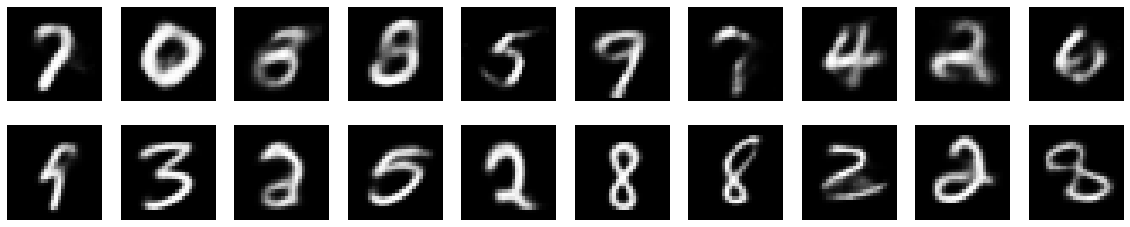

In [56]:
_, plots = pyplot.subplots(nrows=2, ncols=NUM_SAMPLES, figsize=(20, 4))

for index in range(NUM_SAMPLES):
    vae_plot = plots[0, index]
    vae_plot.imshow(vae_generated_images[index], cmap='gray')
    vae_plot.axis('off')

    conv_plot = plots[1, index]
    conv_plot.imshow(conv_generated_images[index], cmap='gray')
    conv_plot.axis('off')

pyplot.show()

These results are worse than expected. We expected to get a clear improvement on the generation process. However it seems images generated using the convolutional VAE are more like numbers than the generated using the original VAE.

We implemented a more powerful encoder and decoder models for the convolutional VAE but there may be some other reasons to get better generated images. We can stare at the prior as this reason. We hypothesize that a gaussian prior may not capture very well the features that make the decoder generate better looking images.

## How well are the encoders at clustering the input data?

The main goal of this notebook is to get a better understanding of the latent space of the variational auto-encoder. The experiments focus on analyzing the capabilities of the representations to separate the classes in a classification data set. We are comparing here the clustering capabilities of the standard auto-encoder and the variational auto-encoder.

### Visualizing the learned latent space

The first experiment we are conducting with the representation from models is to plot a visualization of the representations regarding their classes. For this experiment we use the t-SNE that provides a visualization of high-dimensional data. We expect a clear separation of he representation from the VAE models.

In [57]:
from sklearn.manifold import TSNE

The embeddings from the auto-encoder are calculated this way using the t-SNE algoritm:

In [58]:
ae_representations = simple_encoder(evaluation_images)

tsne = TSNE(n_components=2, learning_rate='auto', init='pca')
ae_embeddings = tsne.fit_transform(ae_representations)

/home/cperez/work/master/code/.venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


We replicate the same code for to get the embeddiongs from the variational auto-encoder:

In [59]:
vae_representations, _ = gaussian_encoder(evaluation_images)

tsne = TSNE(n_components=2, learning_rate='auto', init='pca')
vae_embeddings = tsne.fit_transform(vae_representations)

/home/cperez/work/master/code/.venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


We used more or less the same code to get the embeddings from the convolutional VAE:

In [60]:
conv_representations, _ = convolutional_encoder(evaluation_images)

tsne = TSNE(n_components=2, learning_rate='auto', init='pca')
conv_embeddings = tsne.fit_transform(conv_representations)

/home/cperez/work/master/code/.venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


We are now plotting the embeddings from each of the three models. The image on the left corresponds to the embeddings resulting from the auto-encoder. The center figure corresponds to the embeddings from the original VAE. The image at the right represents the asignments of the embeddings generated using the convolutional VAE:

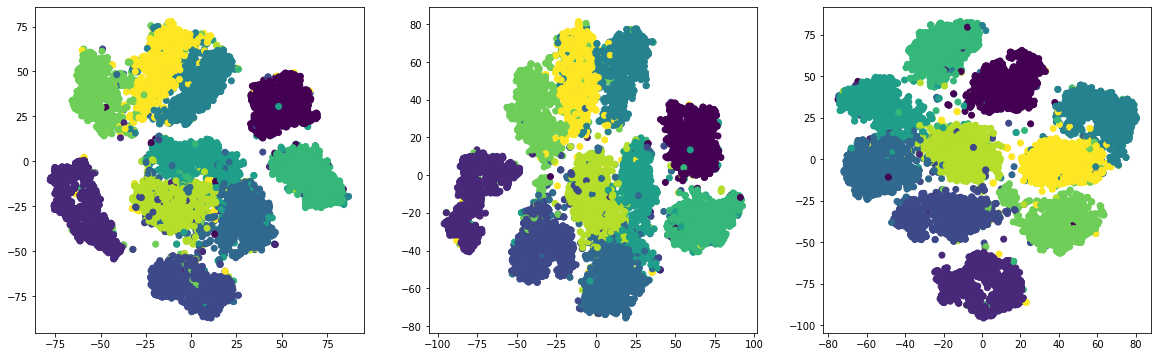

In [61]:
_, plots = pyplot.subplots(nrows=1, ncols=3, figsize=(20, 6))

ae_plot = plots[0]
ae_plot.scatter(ae_embeddings[:, 0], ae_embeddings[:, 1], c=evaluation_labels)
    
vae_plot = plots[1]
vae_plot.scatter(vae_embeddings[:, 0], vae_embeddings[:, 1], c=evaluation_labels)
    
conv_plot = plots[2]
conv_plot.scatter(conv_embeddings[:, 0], conv_embeddings[:, 1], c=evaluation_labels)

pyplot.show()

These results as very dissapointing. It seems clear that the representations returned from VAEs are not better that the representations returned by a standard auto-encoder.

Our hypothesis is that clustering capabilities of the variational auto-encoder may be improved by implementing some variations of the model. For example, one can add some term to the loss function to force the encoder to learn a representation that separate the classes.

### How far are clusters one from another?

We have seen that it seems there is not a big difference between how far are representations from one class to the representations of the other classes. The goal of this experiment is to measure the distances between representations just to make a bit more clear the visualizations above. We do not expect big differences for each model. However, we expect the auto-encoder to provide a better separation since the t-SNE plot shows classes more clearly separated.

For this experiment we are using the _Silhouette_ algorithm. The values resulting from this algorithm are values between -1 and 1. A value for a representation that is close to 1 means that the representation is near the centroid of the class it belongs to. If that value is close to -1 means that the representation is near to the representations of other classes. A representation whse _Silhouette_ value is close to -1 represents an example that may be incorrectly labeled.

In [62]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

import numpy

Let's first define a function to render the silhouette plot:

In [63]:
def plot_silhouettes(plot, values, labels, average=None):
    if average:
        plot.axvline(x=average, color="red", linestyle="--")
        
    y_lower = 10
    for i in range(10):
        ith_cluster_silhouette_values = values[labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        plot.fill_betweenx(
            numpy.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            alpha=0.7,
        )

        plot.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        plot.set_xlim([-0.5, 0.5])

        y_lower = y_upper + 10

We are computing now the _Silhouette_ values for all representations obtained using the encoder trained with the standar auto-encoder. We draw in red the mean _Silhouette_ score for all the evaluation data set:

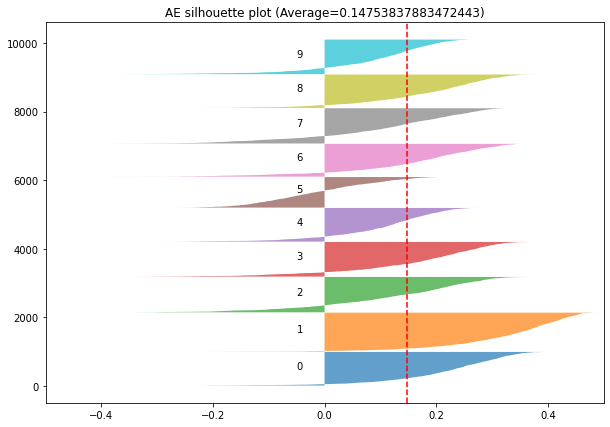

In [64]:
ae_silhouette_score = silhouette_score(ae_representations, evaluation_labels)
ae_silhouette_values = silhouette_samples(ae_representations, evaluation_labels)

_, silhouette = pyplot.subplots(nrows=1, ncols=1, figsize=(10, 7))
plot_silhouettes(
    plot=silhouette,
    values=ae_silhouette_values,
    labels=evaluation_labels,
    average=ae_silhouette_score)

pyplot.title('AE silhouette plot (Average={})'.format(ae_silhouette_score))
pyplot.show()

The same way we are plotting the _Silhouette_ values for the representations of the elements of the evaluation dataset obtained using the variational auto-encoder:

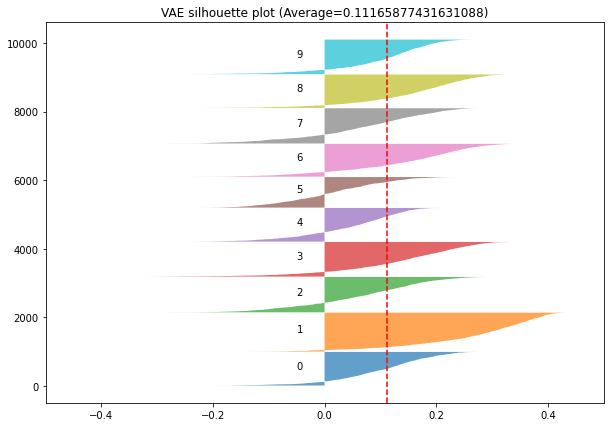

In [65]:
vae_silhouette_score = silhouette_score(vae_representations, evaluation_labels)
vae_silhouette_values = silhouette_samples(vae_representations, evaluation_labels)

_, silhouette = pyplot.subplots(nrows=1, ncols=1, figsize=(10, 7))
plot_silhouettes(
    plot=silhouette,
    values=vae_silhouette_values,
    labels=evaluation_labels,
    average=vae_silhouette_score)

pyplot.title('VAE silhouette plot (Average={})'.format(vae_silhouette_score))
pyplot.show()

Let us finally compute the _Silhoutte_ score using the convolutional VAE:

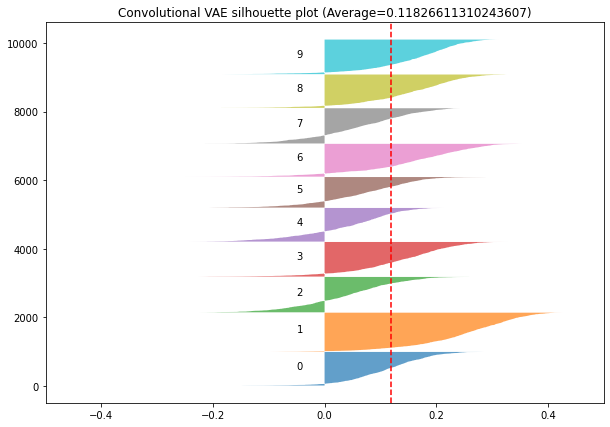

In [66]:
conv_silhouette_score = silhouette_score(conv_representations, evaluation_labels)
conv_silhouette_values = silhouette_samples(conv_representations, evaluation_labels)

_, silhouette = pyplot.subplots(nrows=1, ncols=1, figsize=(10, 7))
plot_silhouettes(
    plot=silhouette,
    values=conv_silhouette_values,
    labels=evaluation_labels,
    average=conv_silhouette_score)

pyplot.title('Convolutional VAE silhouette plot (Average={})'.format(conv_silhouette_score))
pyplot.show()

From the _Silhouette_ scores obtained for the evaluated models confirm the results from the visualization experiments. The standard auto-encoder performs best in the clustering task than the VAE models. On the other hand, the convolutional VAE gets a better Silhouette score (0.1183) than the original VAE (0.1117). However, we consider this difference is not big enough to consider the convolutional VAE performs better than the original VAE.